## Tarea 2, parte 2
### Esteban Jiménez Henríquez

   **1- Calibración**
   
   Los coeficientes de la transformación fueron obtenidos de [Sirianni et al. 2005](http://arxiv.org/pdf/astro-ph/0507614v1.pdf).
   

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Magnitudes obtenidas de la parte 1 
F555W = np.loadtxt('Mag_F555W.txt')
F814W = np.loadtxt('Mag_F814W.txt')

# Convertion to OBMAG system
ZPT_F555W, ZPT_F814W = 25.255, 24.849
F555W = F555W - ZPT_F555W
F814W = F814W - ZPT_F814W

In [3]:
# Transformación
def To_JohnsonCousins (tcol,f):
    if f == 'V':
        if tcol < .6:
            temp = 25.25 - (.09 * tcol) + (.034 * tcol**2)
            
        else:
            temp = 25.275 - (.124 * tcol) + (.018 * tcol**2)
    
    else: 
        if tcol < .1:
            temp = 24.837 + (.06 * tcol) - (.099 * tcol**2) 
        
        else:
            temp = 24.838 + (.001 * tcol) + (.013 * tcol**2)
    return temp

In [4]:
MAG = np.zeros((len(F555W),2),dtype = np.float32)
for i in range(len(F555W)):
    
    f555, f814 = F555W[i], F814W[i]
    TCOL = f555 - f814
    
    for j in range(10):
        V = f555 + To_JohnsonCousins (TCOL, 'V')
        I = f814 + To_JohnsonCousins (TCOL, 'I')
        TCOL = V-I
        
    MAG[i,:] = np.array([V,I])
    
V = MAG[:,0]
I = MAG[:,1]
color = V-I    
del(MAG)

(-1.0, 2.0)

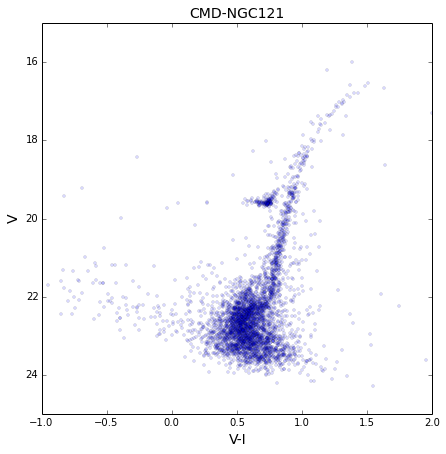

In [5]:
fig,axis = plt.subplots(figsize=(7, 7))
axis.plot(color,V,'bo',alpha=0.15,markersize =3.0)
axis.invert_yaxis()
plt.title('CMD-NGC121', fontsize = 14)
plt.xlabel('V-I', fontsize = 14)
plt.ylabel('V', fontsize = 14)
axis.set_ylim([25,15])
axis.set_xlim([-1.0,2.0])

(25, 15)

/usr/lib/pymodules/python2.7/matplotlib/collections.py:548: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


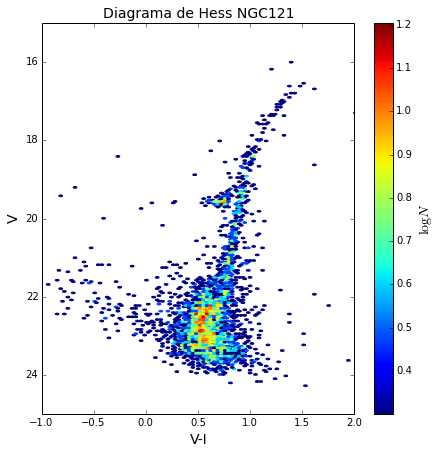

In [6]:
fig = plt.figure(figsize = (7,7))
plt.hexbin(color,V, gridsize=200, bins='log', mincnt=1)
plt.gca().invert_yaxis()
plt.title('Diagrama de Hess NGC121', fontsize = 14)
plt.xlabel('V-I', fontsize = 14)
plt.ylabel('V', fontsize = 14)
cb = plt.colorbar()
cb.set_label(r"$ \log N$", fontsize = 14)
plt.xlim([-1.0,2.0])
plt.ylim([25,15])

### **2- Calculo del Ridge-Line y ajuste de isócrona**
**2.1- Ridge-Line**

In [7]:
def ToClass(X, NBIN, XMIN,XMAX):
    labels = (np.array(X-XMIN)/(XMAX-XMIN)*NBIN).astype(int)
    labels[labels < 0] = 0
    labels[labels >= NBIN] = NBIN-1
    return labels

maxval, minval = 24.0, 16.5
num_bins = 25
delta = (maxval-minval) / num_bins 
i,j = 0,0
mask = (V < 19.7) & (V > 19.1)  & (color < 0.85) 
mask = np.array([not i for i in mask])
V2 = V[mask]
color2 = color[mask]

labels= ToClass(V2,num_bins, minval, maxval)
bin_list = []
    
while j < num_bins:
    r = np.any(labels == j)
    if r == True:
        bin_list.append(j)
    j += 1    

a_0 = minval + delta/2
bins = np.array([ a_0 + delta*n for n in bin_list])
median = np.array([np.median((color2[labels == y])) for y in bin_list])

from scipy.interpolate import interp1d

new_length = 100
new_V = np.linspace(bins.min(), bins.max(), new_length)
new_VI = interp1d(bins, median, kind='cubic')(new_V)

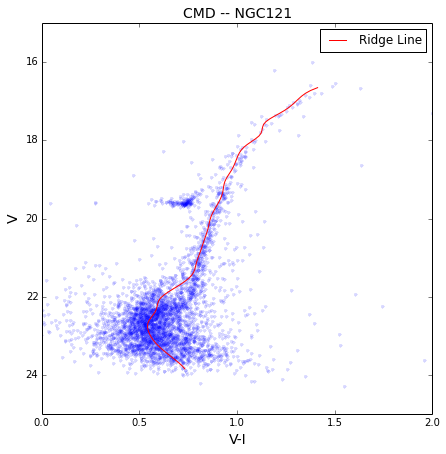

In [8]:
fig,axis = plt.subplots(figsize=(7,7))
axis.plot(color,V,'b.',alpha=0.15)
axis.plot(new_VI,new_V, 'r-', label = 'Ridge Line')
plt.title(r"CMD -- NGC121",fontsize = 14)
plt.xlabel(r"V-I", fontsize = 14)
plt.ylabel(r"V", fontsize = 14)
axis.invert_yaxis()
axis.set_ylim([25,15])
axis.set_xlim([0,2.0])
plt.legend()

**2.2 - Isócrona**

Los valores de metalicidad y edad fueron obtenidos de [Wolf et al. 2006](http://arxiv.org/pdf/astro-ph/0610261v1.pdf) y el módulo de distancia de [NED](https://ned.ipac.caltech.edu/cgi-bin/objsearch?objname=NGC121&extend=no&hconst=73&omegam=0.27&omegav=0.73&corr_z=1&out_csys=Equatorial&out_equinox=J2000.0&obj_sort=RA+or+Longitude&of=pre_text&zv_breaker=30000.0&list_limit=5&img_stamp=YES).

Las magnitudes de la rama horizontal coinciden bien con lo obtenido en la literatura (Ver fig. 10 en [Dolphin et al. 2001](http://arxiv.org/pdf/astro-ph/0107164.pdf)).

In [9]:
mu = 18.91 # Modulo de distancia
age = 10e9 # edad
log_age = np.log10(age)
met = -1.7 # Metalicidad

from isochrones.dartmouth import Dartmouth_Isochrone
iso = Dartmouth_Isochrone(bands=['V','I'])
model = iso.isochrone(log_age,feh = met, dm = 0.0001)
model_v = model.V_mag 
model_i = model.I_mag
model_vi = model_v - model_i

model_v += mu # Corrección por módulo de distancia

/usr/local/lib/python2.7/dist-packages/IPython/kernel/__init__.py:13: ShimWarning: The `IPython.kernel` package has been deprecated. You should import from ipykernel or jupyter_client instead.
  "You should import from ipykernel or jupyter_client instead.", ShimWarning)


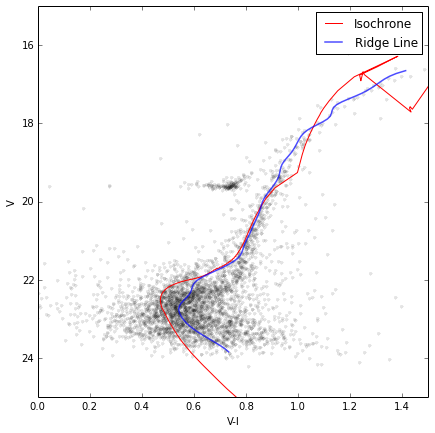

In [10]:
fig, axis = plt.subplots(figsize=(7,7))
axis.plot(color,V,'k.',alpha=0.1)
axis.plot(model_vi,model_v,'r-',label = 'Isochrone')
axis.plot(new_VI,new_V, color = 'blue',linestyle = '-', lw = 1.5, alpha = .7, label = 'Ridge Line')
axis.invert_yaxis()
axis.set_xlabel('V-I')
axis.set_ylabel('V')

axis.set_ylim([25,15])
axis.set_xlim([0,1.5])
plt.legend()